In [210]:
import numpy as np
import networkx as nx
# import rustworkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import islice
# %matplotlib qt
import shapely
import matplotlib.patheffects as pe
import contextily as cx

In [211]:
def distribute(needs,space): #distributes cars, there might be a faster way, but i cannot think of one right now
    endresult=np.zeros(len(needs),dtype=int)
    # filter=needs
    while space>=np.sum((needs>0)):
        add=min(np.min(needs[needs>0]),space//np.sum((needs>0)))
        endresult[needs>0]+=add
        space-=add*np.sum((needs>0))
        needs[needs>0]-=add
    endresult[np.nonzero(needs>0)[0][:space]]+=1
    return endresult
class edge(object):
    def __init__(self,length,speed,lanes,id=0):
        self.length = int(length)
        self.lanes = int(lanes)
        self.speed=int(speed)
        self.cars = np.zeros((int(lanes*length/(4.5+speed/1.8)),5)) #collums: occupied,age,remaining travel time, spawnpoint, destination
        self.id=id
        self.leftthismin_avg=0
        self.leftthismin=0
    def __str__(self): 
        return f"edge {self.id} cars:{np.sum(self.cars[:,0])}"
    def __repr__(self): 
        return f"edge {self.id} cars:{np.sum(self.cars[:,0])}"
    def C(self): #capacity of edge
        return int(self.lanes*self.length/(4.5+self.speed/1.8))
    def tto(self):
        return self.length/self.speed*60/1000
    def update(self):
        Filter = np.nonzero(self.cars[:,0]==1)[0] #Filter for 
        self.cars[Filter,2] -= 1 #travelled one minute
        self.cars[Filter,1] += 1 #aged one minute
        self.leftthismin_avg=(1-smoothing)*self.leftthismin_avg+smoothing*self.leftthismin
        self.leftthismin=0
    def tt_avg(self):
        if np.sum(self.cars[:,0])==0: return self.tto()*0.1 #defaults to tt0 if road is empty
        else: return (max(np.sum(self.cars[self.cars[:,2]>0,2]),1)/np.sum(self.cars[:,0])) #otherwise average the traveltime
    def avg_waittime(self):
        """average time a car waits to pass through node"""
        if np.sum(self.cars[:,2]<0)==0: return 0
        else: return -np.average(self.cars[self.cars[:,2]<0,2])
    def tt(self):
        return self.tto()*(1+0.15*(self.size()/self.C())**4)
    def size(self):
        return sum(self.cars[:,0])
class node(object):
    def __init__(self,inputs=[],output=[],destinations=[],id=0,average=85,sd=1.5):
        self.id=id
        self.output = output
        self.input = inputs
        self.destinations=destinations
        self.dest_weights=[]
        self.waitlist=dict(zip(self.output,[dict(zip(self.input,[np.zeros(0,dtype=int) for j in self.input]))for i in self.output]))
        self.buildup=np.zeros((0,5))
        self.times=np.zeros((0,2)) #array with first collumn as times, and second as origins
        self.gen_average=average
        self.gen_sd=sd
    def initwaitlist(self):
        if len(self.waitlist.keys())>0: print("waitlist already had keys",self.waitlist); return
        else: self.waitlist=dict(zip(self.output,[dict(zip(self.input,[np.zeros(0,dtype=int) for j in self.input]))for i in self.output]))
    def __str__(self): 
        if len(self.buildup): return f"node {self.id} with input: {[i.id for i in self.input]} and output: {[i.id for i in self.output]} and buildup:{len(self.buildup)}"
        else: return f"node {self.id} with input: {[i.id for i in self.input]} and output: {[i.id for i in self.output]}"
    def __repr__(self): 
        if len(self.buildup): return f"node {self.id} with input: {[i.id for i in self.input]} and output: {[i.id for i in self.output]} and buildup:{len(self.buildup)}"
        else: return f"node {self.id} with input: {[i.id for i in self.input]} and output: {[i.id for i in self.output]}"
    def size(self):
        return len(self.buildup)    
    def avg_waittime(self,edge_out):
        if edge_out not in self.output: print(f"what ya doing mate {edge_out} does not exit {self}")
        carswaiting=np.concatenate([i.cars[self.waitlist[edge_out][i],2] for i in self.waitlist[edge_out].keys()])
        if len(carswaiting)==0: return 0.00001
        else:return -np.average(carswaiting)
    def flow(self):
        for i in self.input:
            Remove=np.nonzero(np.logical_and(i.cars[:,4]==self.id,np.logical_and(i.cars[:,2]<=0,i.cars[:,0]==1)))[0]
            self.times=np.concatenate((self.times,i.cars[Remove,:][:,[1,3]])) #remove all cars that have arrived at their destination
            i.cars[Remove,:]=0
            if self.output==[]:print(f"node {self.id} had no output roads") ;continue
            Filter2 = np.nonzero(np.logical_and(i.cars[:,2]==0,i.cars[:,0]==1))[0] #check which cars arrived now
            if len(self.output)==len(self.input)==2: choices=np.full(len(Filter2),[edges for edges in self.output if edges.id !=(i.id[1],i.id[0])][0]) #cars are not allowed to go back, so this is the only option for cars
            else:
                handling=i.cars[Filter2,:] #cars that need to be handled this function call
                choices=np.empty(len(handling),dtype=edge)
                for dest in np.unique(handling[:,4]):
                    routes=list(islice(nx.shortest_simple_paths(gfd,self.id,dest,weight="tt_avg"),len(self.output)-1))
                    a=[gfd.edges[path[:2]]["object"]for path in routes]
                    weights=1/np.array([nx.path_weight(gfd,path,weight="tt_avg") for path in routes])
                    rander=np.random.choice(a,size=sum(handling[:,4]==dest),p=weights/np.sum(weights)) #randomly choose next edge
                    choices[handling[:,4]==dest]=rander
            for indexes in choices:
                if indexes not in self.output: print("fuck")
            for j in self.output:
                self.waitlist[j][i]=np.concatenate((self.waitlist[j][i],np.array(Filter2[choices==j],dtype=int))) #add new indexes along with their location at the end
        for i in self.output:
            if sum([len(self.waitlist[i][j]) for j in self.input])==0: continue #doesn't need to do anything if there are no cars waiting
            elif sum([len(self.waitlist[i][j]) for j in self.input])<=np.sum(i.cars[:,0]==0):
                for j in self.input:
                    filter=np.nonzero(i.cars[:,0]==0)[0][:len(self.waitlist[i][j])]
                    j.leftthismin+=len(filter)
                    i.cars[filter]=j.cars[self.waitlist[i][j],:] #put cars in next edge
                    i.cars[filter,2]=np.maximum(np.ceil(i.tt()+np.random.normal(0,i.tto()/10,size=len(filter))),1)
                    j.cars[self.waitlist[i][j],:]=0 #empty the cars
                    self.waitlist[i][j]=np.zeros(0,dtype=int) #empty waitlist
            else:
                space=np.sum(i.cars[:,0]==0)
                needs=np.array([len(self.waitlist[i][j]) for j in self.input])
                allowances=distribute(needs,space)
                for k,j in enumerate(self.input):
                    j.leftthismin+=allowances[k]
                    filter=np.nonzero(i.cars[:,0]==0)[0][:allowances[k]]
                    i.cars[filter]=j.cars[self.waitlist[i][j][:allowances[k]]] ###probs dont need [filtertje,:] [filtertje] seems enough
                    i.cars[filter,2]=np.maximum(np.ceil(i.tt()+np.random.normal(0,i.tto()/10,size=len(filter))),1)
                    j.cars[self.waitlist[i][j][:allowances[k]],:]=0 #empty the cars
                    self.waitlist[i][j]=self.waitlist[i][j][allowances[k]:]
    def generate(self,destinations=[2]): ##change code to account for more generating cities and differing distributions
        N=int(np.random.normal(self.gen_average,self.gen_sd)+0.5) #+.5 rounds it to the nearest integer
        if N<0: print(N,self)
        newcars=np.array([np.ones(N),np.zeros(N),np.random.normal(0,1,size=N),np.full(N,self.id),np.random.choice(self.destinations,N,p=self.dest_weights)]).transpose()
        newcars=np.concatenate((self.buildup,newcars)) #needs to handle the built up cars first
        if len(self.output)==1: edgelists=np.full(len(newcars),self.output[0])
        elif len(self.output)==2: edgelists=np.array([gfd.edges[paths[self.id][endgoal][:2]]["object"] for endgoal in newcars[:,4]])
        else:
            handling=newcars #cars that need to be handled this function call
            edgelists=np.empty(len(handling),dtype=edge)
            for dest in np.unique(handling[:,4]):
                routes=list(islice(nx.shortest_simple_paths(gfd,self.id,dest,weight="tt_avg"),len(self.output)-1)) #find degree-1 shortest routes
                a=[gfd.edges[path[:2]]["object"]for path in routes] #list of first edges of all routes
                weights=1/np.array([nx.path_weight(gfd,path,weight="tt_avg") for path in routes]) #lengths of all routes
                edgelists[handling[:,4]==dest]=np.random.choice(a,size=sum(handling[:,4]==dest),p=weights/np.sum(weights)) #randomly choose edges
        for i in edgelists:
            if i not in self.output: print("fuck")
        self.buildup=np.zeros((0,5))
        for i in self.output:
            going=edgelists==i
            filter = np.nonzero(i.cars[:,0]==0)[0]
            # print(np.sum(i.cars[:,0]==0),np.sum(going))
            if np.sum(i.cars[:,0]==0)>=np.sum(going): #can go if there are enough spaces for it
                # print("this case")
                i.cars[filter[:np.sum(going)],:]=newcars[going,:]
                i.cars[filter[:np.sum(going)],2]=np.maximum(np.ceil(i.tt()+i.cars[filter[:np.sum(going)],2]*i.tto()/20),1)
            else: 
                spaces=np.sum(i.cars[:,0]==0)
                i.cars[filter,:]=newcars[np.nonzero(going==1)[0][:spaces],:]
                i.cars[filter,2]=np.maximum(np.ceil(i.tt()+i.cars[filter,2]*i.tto()/20),1)
                build=newcars[np.nonzero(going==1)[0][spaces:]] 
                build[:,1]+=1 #update age of cars that stayed in the city
                self.buildup=np.concatenate((self.buildup,build)) #throw all excess cars into the buildup

In [212]:
pops=np.array([95890,44990,34105,15200,13060, 13355, 13015,12965,10370,10120,9960,30680])
20*12*pops/np.sum(pops)

array([75.77491686, 35.55233611, 26.95070956, 12.0114583 , 10.32037141,
       10.55348853, 10.28481117, 10.24529979,  8.19465938,  7.9971025 ,
        7.8706661 , 24.2441803 ])

In [213]:
smoothing=1/4
runnr=2
stadnamen=['Leeuwarden', 'Drachten', 'Sneek', 'Heerenveen', 'Harlingen','Joure', 'Wolvega', 'Franeker', 'Dokkum', 'Lemmer', 'Bolsward','Burgum']
spawn_hoeveelheden={160: 20.0, 199: 20.0, 'Leeuwarden': 66.0, 'Drachten': 36.0, 'Sneek': 27.0, 'Harlingen': 12.0, 'Joure': 10.0, 'Wolvega': 11.0, 'Franeker': 10.0, 'Dokkum': 10.0, 'Lemmer': 10.0, 'Bolsward': 10.0, 'Burgum': 10.0, 'Heerenveen': 24.0}

In [ ]:
nodes_gpd = gpd.read_file('./wegengraaf3/points.shp')
lines_gpd = gpd.read_file('./wegengraaf3/lines.shp')

In [214]:
nodes_gpd = gpd.read_file('./wegengraaf2/points.shp')
lines_gpd = gpd.read_file('./wegengraaf2/lines.shp')
change_to_2=[(201,202),(202,35),(35,225),(225,105),"N356","031",(123,256),(256,219),(219,160)]
def update_lanes_to2(row):
    if (row["node_end"],row["node_start"]) in change_to_2 or (row["node_start"],row["node_end"]) in change_to_2 or row["wegnr"] in change_to_2:
        row["nbanen"]=2
    return row
lines_gpd=lines_gpd.apply(update_lanes_to2,axis=1)
lines_gpd["capacity"]=lines_gpd['length']*lines_gpd['nbanen']*1/(4.5+lines_gpd['maxshd']/1.8)
nodes_gpd["is_auto_br"][np.isnan(nodes_gpd["is_auto_br"])]=0
nodes_gpd["spawn_hoev"][np.isnan(nodes_gpd["spawn_hoev"])]=0

nodes_gpd["spawn_hoev"][nodes_gpd["nodeID"]==160],nodes_gpd["is_auto_br"][nodes_gpd["nodeID"]==160]=      spawn_hoeveelheden[160],1
nodes_gpd["spawn_hoev"][nodes_gpd["nodeID"]==199],nodes_gpd["is_auto_br"][nodes_gpd["nodeID"]==199]=      spawn_hoeveelheden[199],1 #afsluitdijk
for name in stadnamen:
    nodes_gpd["spawn_hoev"][nodes_gpd["stad_naam"]==name]=spawn_hoeveelheden[name]

C:\Users\Alexander\AppData\Local\Temp\ipykernel_1124\3337991053.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_gpd["is_auto_br"][np.isnan(nodes_gpd["is_auto_br"])]=0
C:\Users\Alexander\AppData\Local\Temp\ipykernel_1124\3337991053.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_gpd["spawn_hoev"][np.isnan(nodes_gpd["spawn_hoev"])]=0
C:\Users\Alexander\AppData\Local\Temp\ipykernel_1124\3337991053.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (whi

In [215]:
def create_graph(nodes_gpd, lines_gpd):
    gf = nx.Graph()
    for _, k in nodes_gpd.iterrows():
        gf.add_node(int(k['nodeID']),
                    x=k['geometry'].x,
                    y=k['geometry'].y,
                    stad_naam=k['stad_naam'],
                    is_auto_br=k['is_auto_br'],
                    spawn_hoev=k['spawn_hoev'])
    for _, row in lines_gpd.iterrows():
        gf.add_edge(int(row['node_start']), int(row['node_end']),
                    wegnr=row['wegnr'],
                    length=row['length'],
                    maxshd=row['maxshd'],
                    nbanen=row['nbanen'])
    return gf

gfd = nx.DiGraph(create_graph(nodes_gpd, lines_gpd))


In [216]:
def weight_edge_min(f, t, attr):
    return attr['length']/attr['maxshd']/1000*60

def weight_edge_dist(f, t, attr):
    return attr['length']

def weight_capacity(f, t, attr):
    cars = np.sum(attr['object'].cars[:, 0])
    capacity = attr['object'].C()
    return attr['length']/attr['maxshd']/1000*60 * (1 + cars/capacity)

def to_directed(gfd, lines_gpd):
    gfd_dir = nx.DiGraph()
    # for n in gfd.nodes():
    #     gfd_dir.add_node(n, x=gfd.nodes[n]['x'], y=gfd.nodes[n]['y'])
    for _, k in nodes_gpd.iterrows():
        gfd_dir.add_node(int(k['nodeID']),
                    x=k['geometry'].x,
                    y=k['geometry'].y,
                    stad_naam=k['stad_naam'],
                    is_auto_br=k['is_auto_br'],
                    spawn_hoev=k['spawn_hoev'])

    for _, row in lines_gpd.iterrows():
        gfd_dir.add_edge(int(row['node_start']), int(row['node_end']),
                    wegnr=row['wegnr'],
                    length=row['length'],
                    maxshd=row['maxshd'],
                    nbanen=row['nbanen'])
    
    return gfd_dir

In [217]:
def make_homogeneous(lines_gpd):
    changed = 0
    # paths = nx.single_source_shortest_path(gfd, 1000)
    for n in gfd.nodes:
        path_node = nx.shortest_path(gfd, 1000, n, weight=weight_edge_min)
        if len(path_node) > 2:
            previous_node = path_node[-2]
            # if exists path from prev to current node
            df_query = lines_gpd[(lines_gpd['node_start'] == previous_node) & (lines_gpd['node_end'] == n)]
            if len(df_query) == 0:
                changed += 1
                def update_row(row):
                    if row['node_end'] == previous_node and row['node_start'] == n:
                        row['node_start'] = previous_node
                        row['node_end'] = n
                    return row
                # switch
                lines_gpd = lines_gpd.apply(update_row, axis=1)
    print(f"{changed=}")
    return lines_gpd

def make_homogeneous2(lines_gpd):
    changed = 0
    # paths = nx.single_source_shortest_path(gfd, 1000)
    degree_highs = [n for n in gfd.nodes if gfd.out_degree(n) > 2]
    # print(len(degree_highs))
    for n in degree_highs:
        def custom_weight(f, t, attr):
            if (f != n and t != n) and (gfd.out_degree(f) > 2 or gfd.out_degree(t) > 2):
                return 900_000
            return weight_edge_min(f, t, attr)
        paths = nx.all_pairs_dijkstra(gfd, cutoff=999_999, weight=custom_weight)
        paths = dict(paths)
        weights, paths = paths[n]
        end_points = [k for k, v in weights.items() if gfd.out_degree(k) != 2 and k != n]
        for end_point in end_points:
            path = paths[end_point]
            for i in range(0, len(path) - 1):
                current = path[i]
                next = path[i+1]
                def update_row(row):
                        if row['node_end'] == current and row['node_start'] == next:
                            # changed += 1
                            row['node_start'] = current
                            row['node_end'] = next
                        return row
                
                lines_gpd = lines_gpd.apply(update_row, axis=1)
            # print(n, end_point, paths[end_point])

    print(f"{changed=}")
    return lines_gpd


lines_gpd = make_homogeneous2(lines_gpd)

# before=lines_gpd.copy()
# lines_gpd = make_homogeneous(lines_gpd)
# print(lines_gpd==before)
gfd = nx.DiGraph(create_graph(nodes_gpd, lines_gpd))

changed=0


In [218]:
# gfd_dir = to_directed(gfd, lines_gpd)

lgpd = lines_gpd.copy()
removed_nodes = list()


for _ in range(999999):
    simplify_roads = list()
    # get suitable roads to simplify
    gfd_dir = to_directed(gfd, lgpd)
    node2 = [u for u in [j for j in gfd_dir.nodes if gfd_dir.out_degree(j) == 1] if gfd_dir.in_degree(u) == 1]
    for r in removed_nodes:
        if r in node2:
            print('removed', r)
            node2.remove(r)
    
    for n in node2:
        edge1 = list(gfd_dir.in_edges(n))[0]
        edge2 = list(gfd_dir.out_edges(n))[0]
        propequal = ['wegnr', 'maxshd', 'nbanen']
        if np.all([gfd_dir.edges[edge1][prop] == gfd_dir.edges[edge2][prop] for prop in propequal]):
            simplify_roads.append((edge1, edge2))

    if len(simplify_roads) == 0:
        break

    f = simplify_roads[0][0]
    t = simplify_roads[0][1]
    from_row = lgpd[(lgpd['node_start'] == f[0]) & (lgpd['node_end'] == f[1])]
    to_row = lgpd[(lgpd['node_start'] == t[0]) & (lgpd['node_end'] == t[1])]
    
    geo1 = from_row.geometry.to_list()[0]
    geo2 = to_row.geometry.to_list()[0]
    dataf = gfd_dir.edges[(f[0], f[1])]
    datat = gfd_dir.edges[(f[0], f[1])]
    removed_nodes.append(f[1])
    df2 = gpd.GeoDataFrame(data={
        'wegnr': [dataf['wegnr']], 
        'length': [dataf['length'] + datat['length']],
        'maxshd': [dataf['maxshd']],
        'node_start': [f[0]],
        'node_end': [t[1]],
        'nbanen': [dataf['nbanen']]},
        geometry=[shapely.ops.linemerge(shapely.geometry.MultiLineString([geo1, geo2]))],
        crs=lgpd.crs)
    print(f"{f[0]} -> {f[1]} => {t[0]} -> {t[1]}")
    lgpd = lgpd.drop([from_row.index[0], to_row.index[0]], axis=0)
    print(from_row.index[0], to_row.index[0])
    lgpd = pd.concat([lgpd, df2], ignore_index=True)
    print('changed')
    # break
    
    

501 -> 1 => 1 -> 0
276 0
changed
218 -> 4 => 4 -> 3
5 4
changed
251 -> 17 => 17 -> 18
19 18
changed
28 -> 27 => 27 -> 112
28 29
changed
44 -> 29 => 29 -> 30
29 28
changed
44 -> 30 => 30 -> 31
332 28
changed
158 -> 37 => 37 -> 38
37 36
changed
190 -> 39 => 39 -> 98
36 37
changed
41 -> 42 => 42 -> 43
36 38
changed
128 -> 47 => 47 -> 120
41 40
changed
55 -> 53 => 53 -> 54
46 45
changed
186 -> 55 => 55 -> 54
46 326
changed
232 -> 58 => 58 -> 56
51 47
changed
60 -> 61 => 61 -> 161
52 53
changed
176 -> 62 => 62 -> 59
52 51
changed
64 -> 65 => 65 -> 23
54 25
changed
68 -> 67 => 67 -> 66
55 53
changed
182 -> 69 => 69 -> 70
56 55
changed
182 -> 70 => 70 -> 71
319 55
changed
74 -> 73 => 73 -> 72
60 56
changed
173 -> 74 => 74 -> 72
59 317
changed
114 -> 79 => 79 -> 10
63 9
changed
80 -> 81 => 81 -> 83
62 64
changed
88 -> 84 => 84 -> 85
66 65
changed
92 -> 89 => 89 -> 90
72 71
changed
92 -> 90 => 90 -> 91
312 71
changed
66 -> 94 => 94 -> 93
52 75
changed
97 -> 96 => 96 -> 98
78 79
changed
100 -> 1

In [219]:
nodes_gpd

,x,y,nodeID,stad_naam,is_auto_br,spawn_hoev,geometry
0,634450.287500,7.034872e+06,0.0,None,0.0,0.0,POINT (634450.288 7034871.712)
1,631261.700000,7.034494e+06,1.0,None,0.0,0.0,POINT (631261.7 7034493.5)
2,678454.257259,6.976978e+06,2.0,None,0.0,0.0,POINT (678454.257 6976977.584)
3,675386.000000,6.974835e+06,3.0,None,0.0,0.0,POINT (675386 6974834.7)
4,673755.301869,6.973613e+06,4.0,None,0.0,0.0,POINT (673755.302 6973612.649)
...,...,...,...,...,...,...,...
272,645666.378142,6.456664e+05,702.0,None,0.0,0.0,POINT (645666.378 7018396.208)
273,639164.832504,6.391648e+05,703.0,None,0.0,0.0,POINT (639164.833 7021021.445)
274,645717.000000,7.021137e+06,704.0,None,0.0,0.0,POINT (645716.65 7021136.551)
275,645058.000000,7.021128e+06,705.0,None,0.0,0.0,POINT (644228.664 7020823.868)


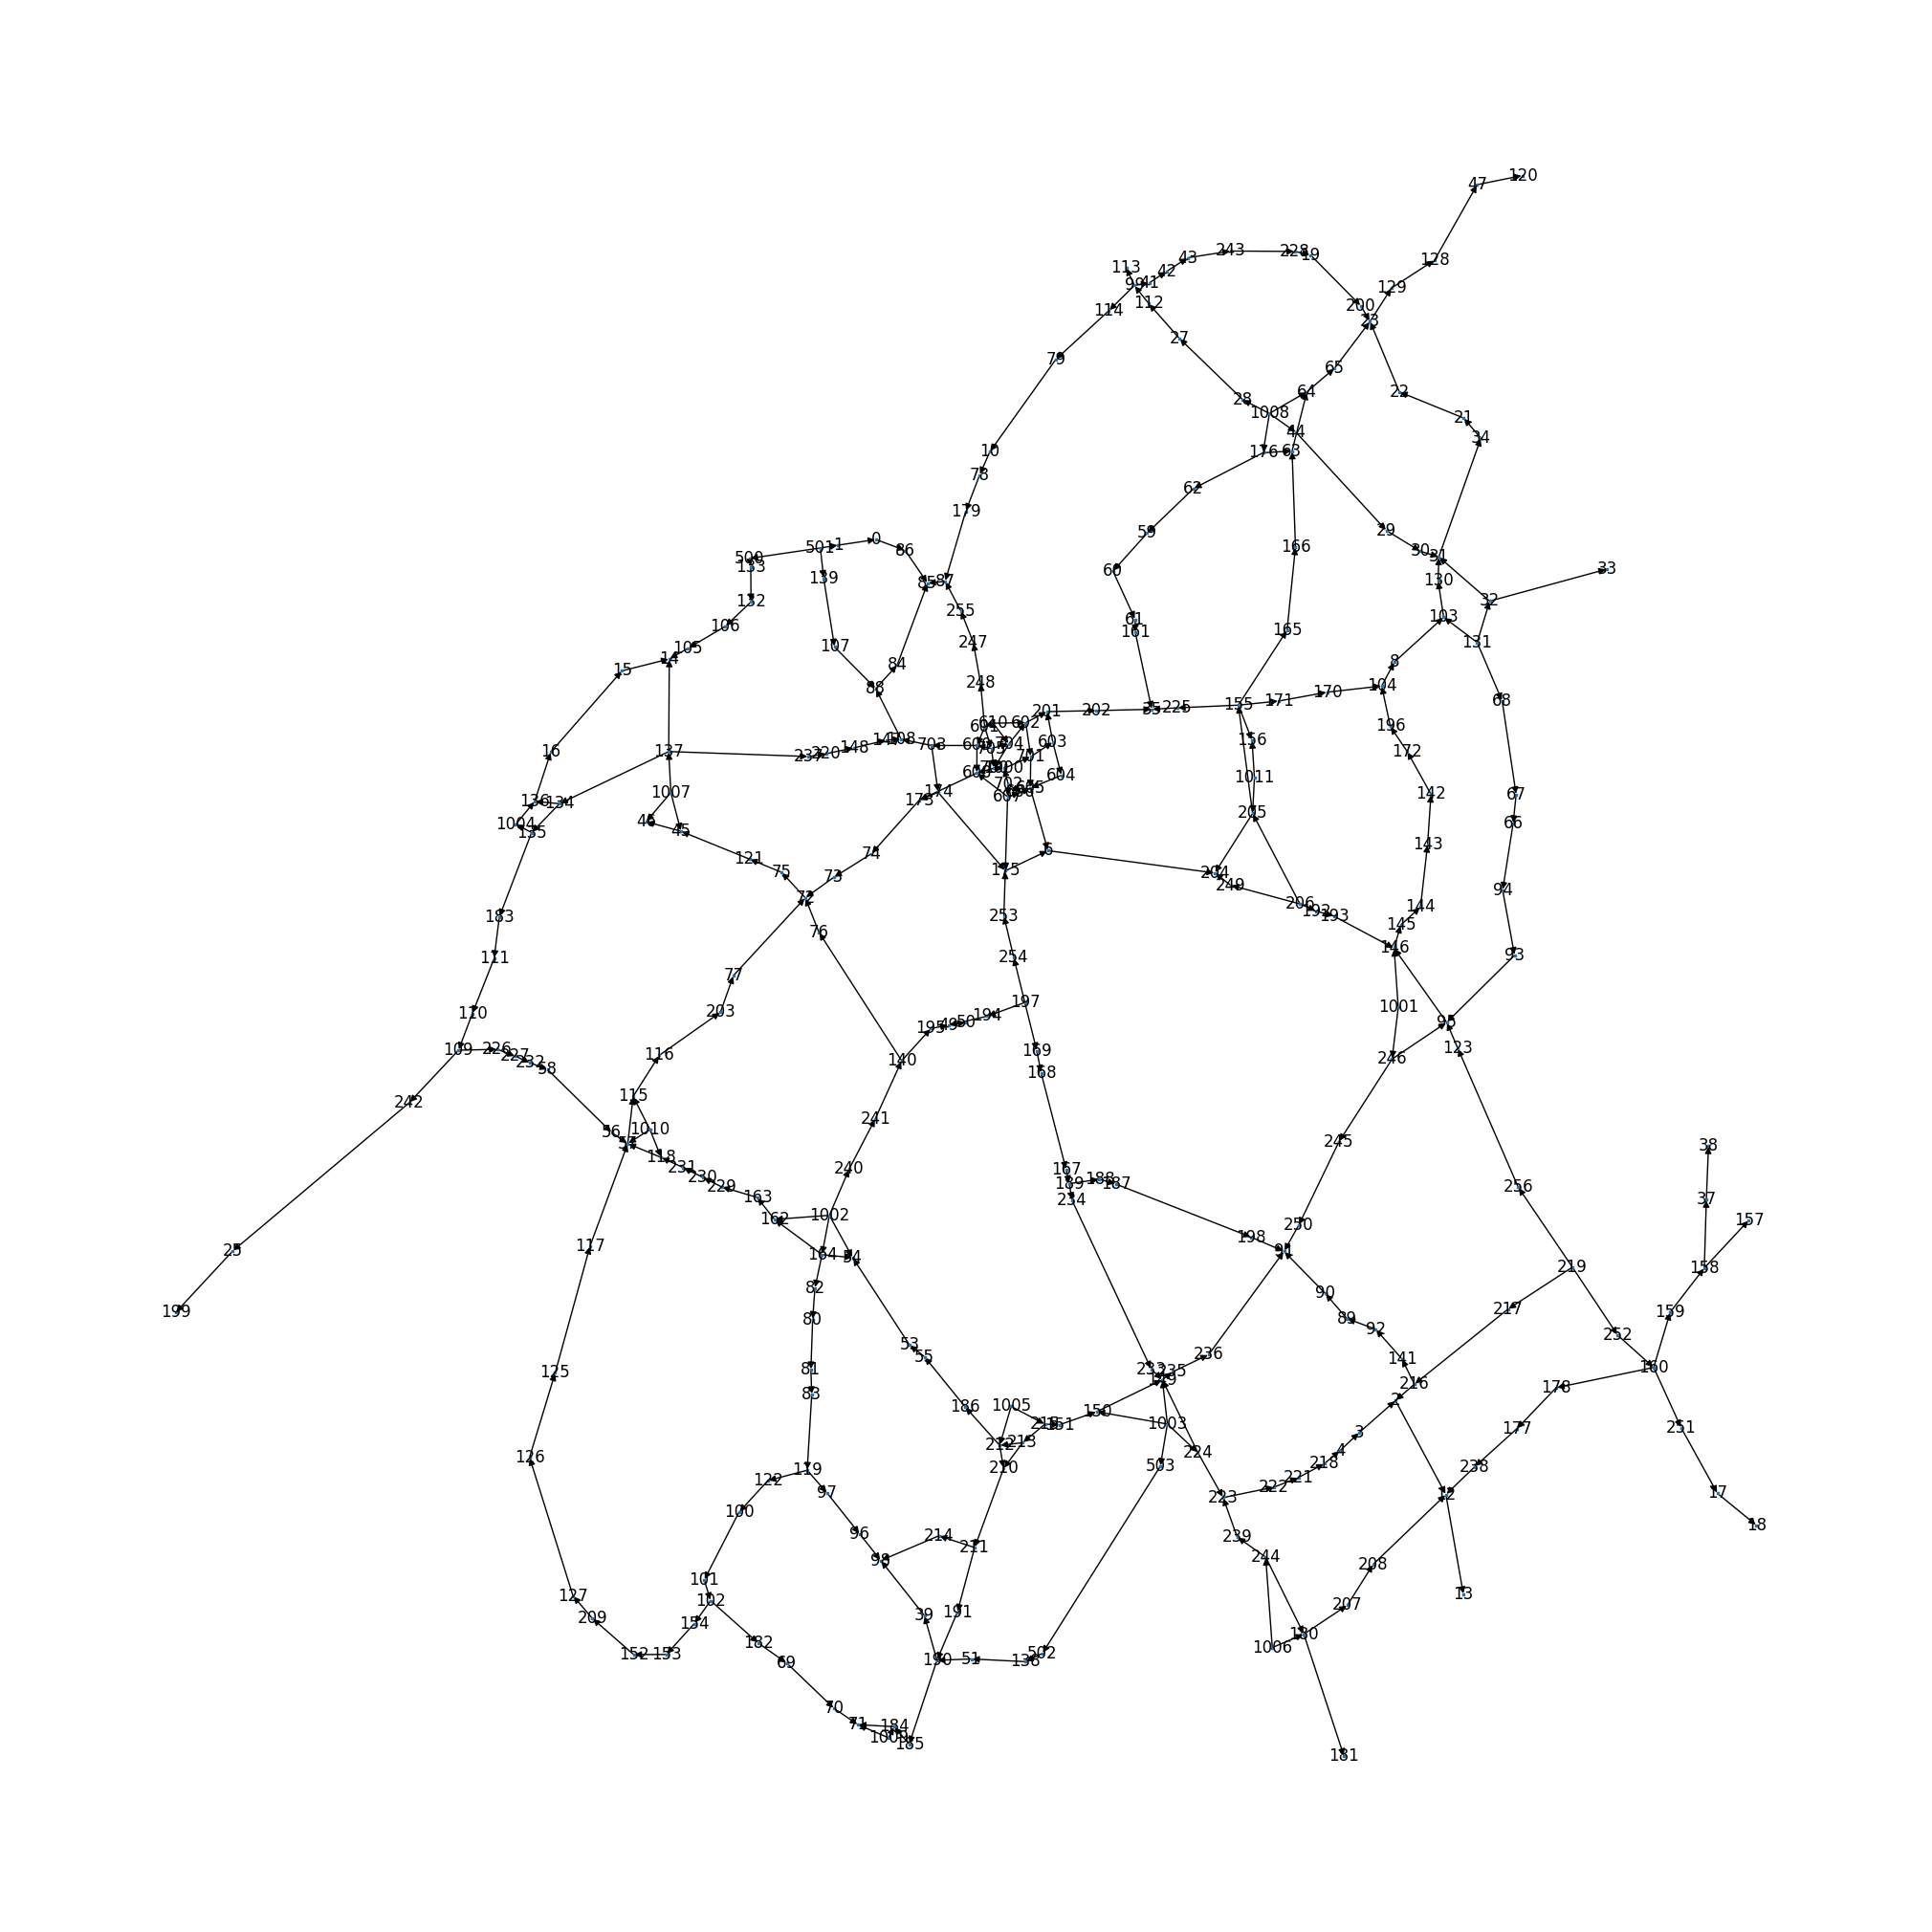

In [220]:
def draw_directed(gfd, lgpd):
    gfd_dir = nx.DiGraph()
    for n in gfd.nodes():
        gfd_dir.add_node(n, x=gfd.nodes[n]['x'], y=gfd.nodes[n]['y'])

    for _, row in lgpd.iterrows():
        gfd_dir.add_edge(int(row['node_start']), int(row['node_end']),
                    wegnr=row['wegnr'],
                    length=row['length'],
                    maxshd=row['maxshd'],
                    nbanen=row['nbanen'])

    plt.figure(figsize=(20, 20))
    pos = {n: [gfd.nodes[n]['x'], gfd.nodes[n]['y']] for n in list(gfd_dir.nodes)}
    nx.draw(gfd_dir, pos=pos, with_labels=True, node_shape='s', node_size=1)

    # subgr = nx.DiGraph(gfd.subgraph(path))
    # nx.draw_networkx_edges(subgr, pos={n: [gfd.nodes[n]['x'], gfd.nodes[n]['y']] for n in list(gfd.nodes)},
    #                     edge_color=colors[i], width=15, style=style[i])
    # i += 1

    plt.show()

draw_directed(gfd, lines_gpd)
gfd = to_directed(gfd, lgpd)
not_removed_nodes = [n for n in gfd.nodes if n not in removed_nodes]
for r in removed_nodes:
    row = nodes_gpd[nodes_gpd['nodeID'] == r]
    nodes_gpd = nodes_gpd.drop([row.index[0]])

gfd = nx.Graph(gfd.subgraph(not_removed_nodes))
lines_gpd = lgpd
# draw_directed(gfd, lgpd)
gfd = to_directed(gfd, lgpd)
nodes_gpd = nodes_gpd.reset_index()

### Running the model

In [221]:
sources=nodes_gpd["nodeID"][np.nonzero(nodes_gpd["is_auto_br"])[0]]
weights=nodes_gpd["spawn_hoev"][np.nonzero(nodes_gpd["is_auto_br"])[0]]
# sources=[1000,1001,1002]
nx.set_edge_attributes(gfd,{e: edge(gfd.edges[e]["length"],gfd.edges[e]["maxshd"],gfd.edges[e]["nbanen"],id=e) for e in gfd.edges},"object") #put edge objects on the edges
nx.set_node_attributes(gfd,{n: node(inputs=[gfd.edges[e]["object"] for e in gfd.in_edges(n)],output=[gfd.edges[e]["object"] for e in gfd.out_edges(n)],id=n, average=gfd.nodes[n]["spawn_hoev"],sd=1.5) for n in gfd.nodes},"object") 
#put node objects on nodes
for i in sources:
    gfd.nodes[i]["object"].destinations=list(sources[sources!=i])
    gfd.nodes[i]["object"].dest_weights=list(weights[sources!=i]/sum(weights[sources!=i])) #destination is any city except source

In [222]:
# gfd.edges[(99,41)]["object"].tto()+gfd.edges[(42,41)]["object"].tto()

In [223]:
minutes_init=0 #initialisation time
minutes_sim=180 #simulation time

sources=nodes_gpd["nodeID"][np.nonzero(nodes_gpd["is_auto_br"])[0]]
# sources=[1000,1001,1002]

cars_forw=np.zeros((len(lines_gpd),minutes_sim))
cars_backw=np.zeros((len(lines_gpd),minutes_sim))
def tt_avg(f, t, attr):
    return attr['object'].tt_avg()+attr['object'].avg_waittime() #average waittime is remaning time plus wait time at end of edge
for minute in range(minutes_init):
    nx.set_edge_attributes(gfd,{e: (gfd.edges[e]["object"].tt_avg()+gfd.nodes[e[0]]["object"].avg_waittime(gfd.edges[e]["object"]))*(1+gfd.edges[e]["object"].size()/gfd.edges[e]["object"].C()) for e in gfd.edges},"tt_avg") #put edge objects on the edges
    paths={n: b for (n, (a, b)) in nx.all_pairs_dijkstra(gfd, weight="tt_avg")}
    for i in sources:
        # print(i,gfd.nodes[i]["object"])
        gfd.nodes[i]["object"].generate() #generate cars at all sources
    for e in gfd.edges:
        # print(e,gfd.edges[e]["object"])
        gfd.edges[e]["object"].update()
    for n in gfd.nodes:
        # print(n,gfd.nodes[n]["object"])
        gfd.nodes[n]["object"].flow()
for i in sources: gfd.nodes[i]["object"].times=np.zeros((0,2))
for minute in range(minutes_sim):
    print(minute, end=', ')
    nx.set_edge_attributes(gfd,{e: (gfd.edges[e]["object"].tt_avg()+gfd.nodes[e[0]]["object"].avg_waittime(gfd.edges[e]["object"]))*(1+gfd.edges[e]["object"].size()/gfd.edges[e]["object"].C()) for e in gfd.edges},"tt_avg") #put edge objects on the edges
    paths={n: b for (n, (a, b)) in nx.all_pairs_dijkstra(gfd, weight="tt_avg")}
    for i in sources:
    # print(i,gfd.nodes[i]["object"])
        gfd.nodes[i]["object"].generate() #generate cars at all sources
    for e in gfd.edges:
        # print(e,gfd.edges[e]["object"])
        gfd.edges[e]["object"].update()
    for n in gfd.nodes:
        # print(n,gfd.nodes[n]["object"])
        gfd.nodes[n]["object"].flow()
    for index,(start,end) in enumerate(zip(lines_gpd["node_start"],lines_gpd["node_end"])):
        # if (start,end) in gfd.edges:
        cars_forw[index,minute]=gfd.edges[(start,end)]["object"].size()
        cars_backw[index,minute]=gfd.edges[(end,start)]["object"].size()
        # else: continue

for i in range(9999):
    lines_gpd = lines_gpd.drop(columns=[f'f{i}'], errors='ignore')
    lines_gpd = lines_gpd.drop(columns=[f'b{i}'], errors='ignore')

cars_forw_pd=pd.DataFrame(cars_forw,columns=[f"f{i}" for i in range(minutes_sim)])
cars_backw_pd=pd.DataFrame(cars_backw,columns=[f"b{i}" for i in range(minutes_sim)])
lines_gpd=pd.concat((lines_gpd,pd.DataFrame(cars_forw_pd),cars_backw_pd),axis=1)


0, 

ValueError: need at least one array to concatenate

In [63]:
def gen_text(string):
    row_index = traffic_map.index[traffic_map['name'] == string]
    if "City" in string:
        return "City " + string[-1]
    elif 'Node' in string:
        if row_index!=None:
            num_of_car = traffic_map.loc[row_index[0], 'cars']
            return '\n' + string[-1] + f'\n cars: {num_of_car}'
        else:
            return '\n' + string[-1] + '\n cars: Not found'
    elif 'Edge' in string:
        if row_index!=None:
            num_of_car = traffic_map.loc[row_index[0], 'cars']
            return f'cars: {num_of_car}'
        else:
            return 'cars: Not found'
    else:
        return ''
def gen_text_lines(index):
    return lines_gpd["wegnr"][index]+"\n"+str(lines_gpd["cars"][index])



In [65]:
line_offset = 850
left_shift = lines_gpd.copy()

def is_rightsided(geom): # is northeast or southeast
    dx = geom.coords[-1][0] - geom.coords[0][0]
    return dx > 0

left_shift['geometry'] = left_shift.geometry.apply(lambda k: k if is_rightsided(k) else k.reverse())
manual_indices = [137, 103, 280, 164, 80, 123, 85, 86, 173, 175, 176]

def update_offset(row):
    if row.name in manual_indices: # row.name is index
        return row.geometry.offset_curve(line_offset)
    return row.geometry.offset_curve(-line_offset)

left_shift['geometry'] = left_shift.apply(update_offset, axis=1)
cities = gpd.read_file('./wegengraaf2/cities.shp').to_crs(epsg=3857)
# left_shift[left_shift['node_start'] == 142]

<timed exec>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
<timed exec>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


58, CPU times: total: 1.52 s
Wall time: 1.51 s


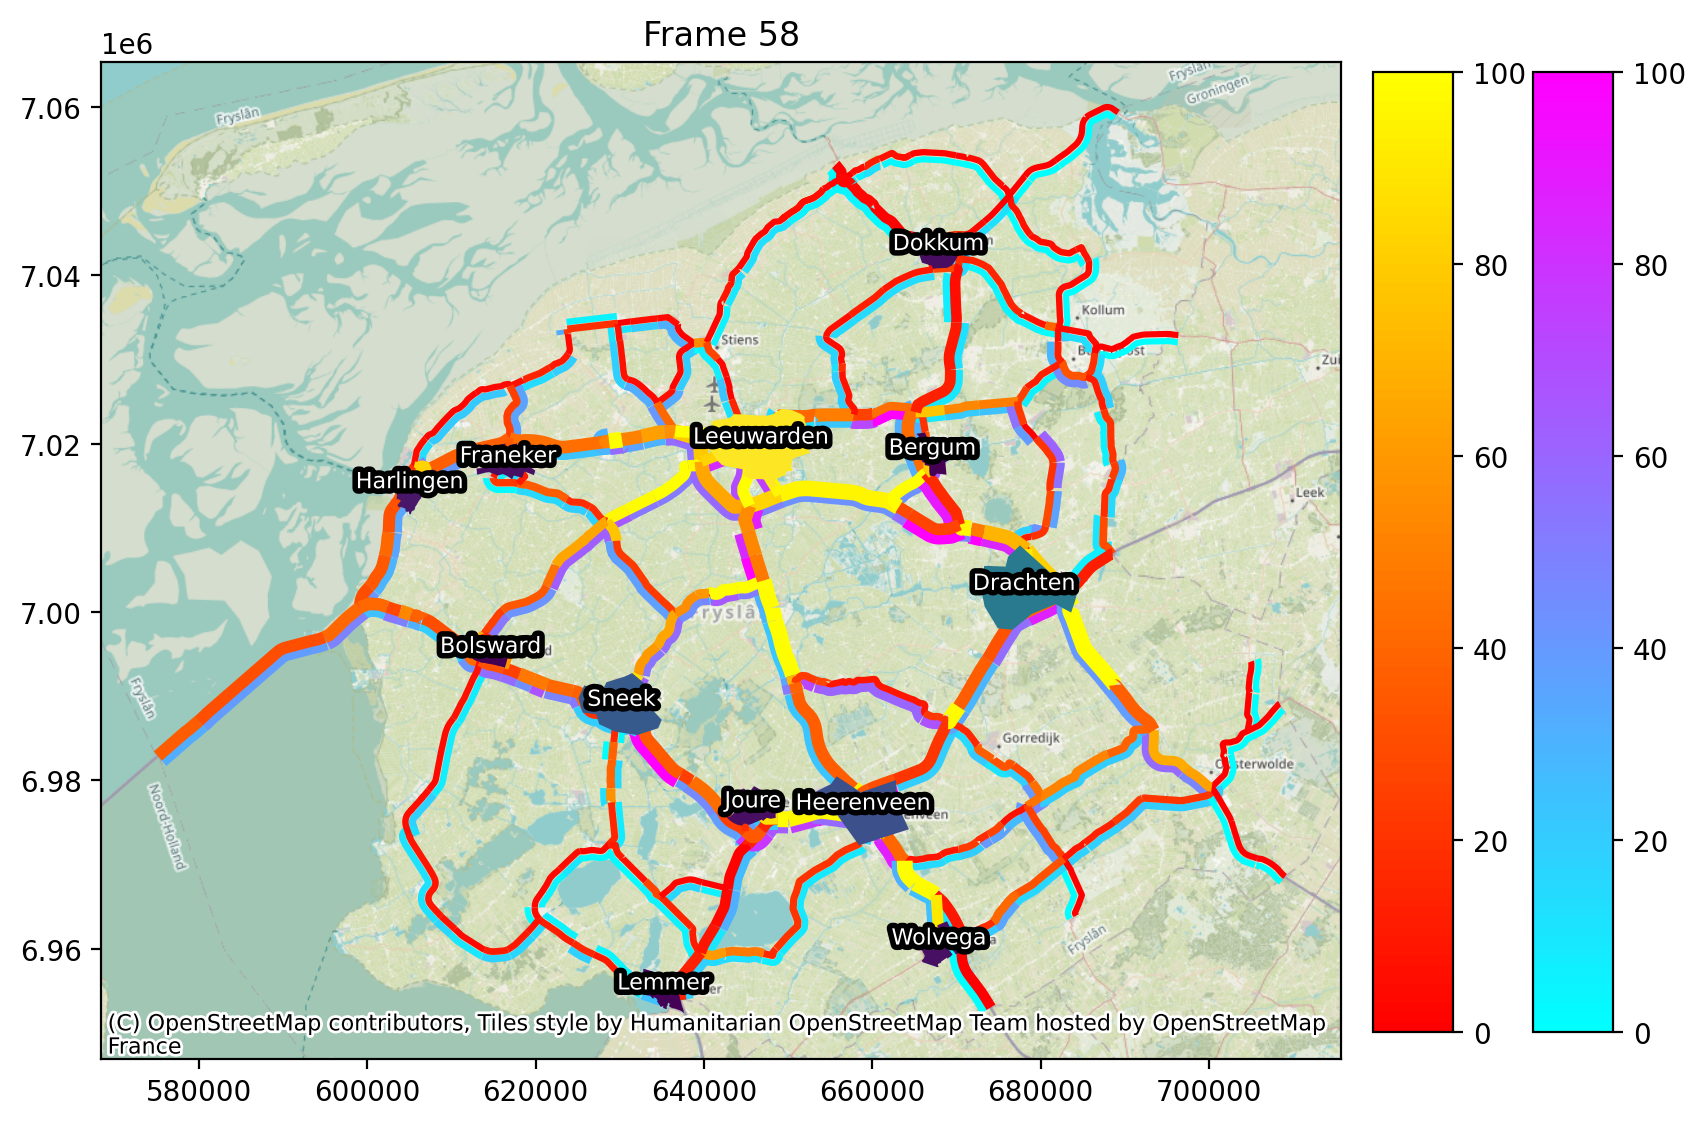

In [66]:
%%time
plt.figure(figsize=(8,8), dpi=200)
ax = plt.subplot()

cmap = plt.cm.get_cmap('autumn', 100)
cmap2 = plt.cm.get_cmap('cool', 100)

cax = plt.axes([0.92, 0.2, 0.05, 0.6])
cax2 = plt.axes([0.92+0.1, 0.2, 0.05, 0.6])

def update(i):
    ax.clear()
    ax.set_title(f"Frame {i}")

    left_shift.plot(ax=ax, column=lines_gpd[f"b{i}"]/lines_gpd["capacity"],
                    cmap='cool',
                    linewidth=0.7+lines_gpd['nbanen']*1.5 + 2*lines_gpd[f"b{i}"]/lines_gpd["capacity"],
                    zorder=1)
    lines_gpd.plot(ax=ax, column=lines_gpd[f"f{i}"]/lines_gpd["capacity"],
                    cmap='autumn',
                    linewidth=0.7+lines_gpd['nbanen']*1.5 + 2*lines_gpd[f"f{i}"]/lines_gpd["capacity"],
                    zorder=1)
    
    # nodes_gpd.plot(ax=ax, markersize=10, color='black', zorder=2)
    cities.plot(ax=ax, 
            column='population')
    cities.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], size=8, ha='center', color='white', path_effects=[pe.withStroke(linewidth=4, foreground="black")]), axis=1)
        
    cx.add_basemap(ax)

    
    bar_info = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax, ax=ax)
    bar_info = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax2, ax=ax)

    # plt.tight_layout()
    plt.savefig('./img2/%02d.png' % i, dpi=200, bbox_inches='tight')
    print('%02d' % i, end=', ')

for k in range(58, 59): # minutes_sim
    update(k)


# ffmpeg -framerate 1 -i %02d.png -c:v libx264 -pix_fmt yuv420p -r 25 output.mp4 -y

----

In [103]:
# for e in gfd.edges:
nx.set_edge_attributes(gfd,{e: (gfd.edges[e]["object"].tt()+gfd.nodes[e[0]]["object"].avg_waittime(gfd.edges[e]["object"])) for e in gfd.edges},"tt_avg")

In [105]:
exavg = nx.shortest_path_length(gfd, 1000, 1006, weight='tt_avg')
exavg

np.float64(48.72836531963748)

In [115]:
paths = nx.shortest_path(gfd, 1000, 1006, weight='tt_avg')
# print(paths)
for i in range(len(paths) - 1):
    edge = (paths[i], paths[i+1])
    occupied = gfd.edges[edge]['object'].size()/gfd.edges[edge]['object'].C()
    print(paths[i], paths[i+1], int(gfd.edges[edge]['length']), occupied)

1000 175 4683 0.9448275862068966
175 253 1909 0.6666666666666666
253 254 1753 0.603448275862069
254 197 1900 0.8888888888888888
197 169 2037 0.47761194029850745
169 168 935 0.39473684210526316
168 167 4108 1.0
167 189 589 0.3684210526315789
189 234 696 0.43478260869565216
234 233 8157 0.6568265682656826
233 149 713 1.0
149 224 3505 0.23076923076923078
224 223 2246 0.581081081081081
223 239 1843 0.3442622950819672
239 244 1674 0.23636363636363636
244 1006 3621 0.29464285714285715


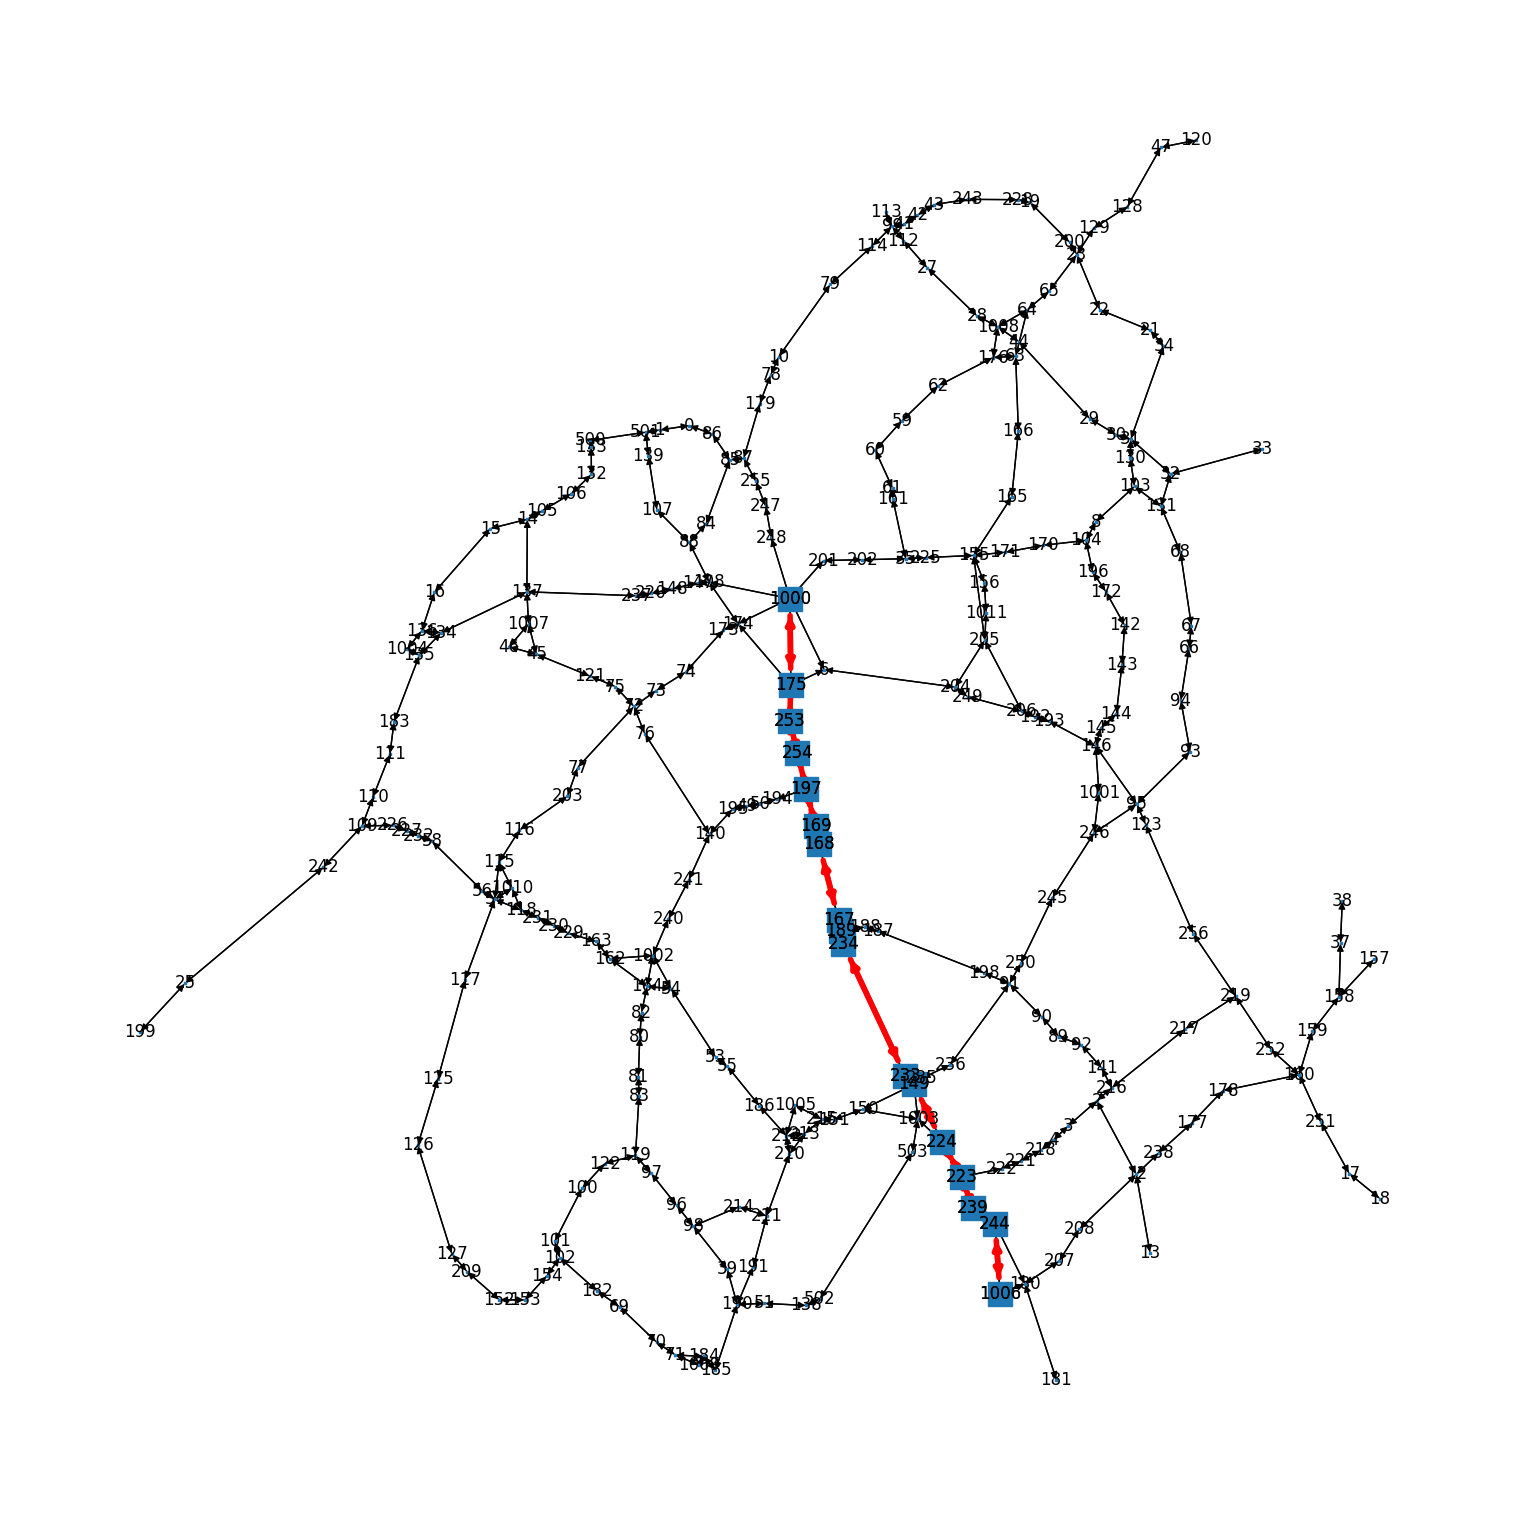

In [127]:
plt.figure(figsize=(15, 15))
nx.draw(gfd, pos={n: [gfd.nodes[n]['x'], gfd.nodes[n]['y']] for n in list(gfd.nodes)}, with_labels=True, node_shape='s', node_size=1)
chosen_path = nx.subgraph(gfd, paths)
chosen_graph = nx.Graph(chosen_path)
nx.draw(chosen_path, pos={n: [chosen_path.nodes[n]['x'], chosen_path.nodes[n]['y']] for n in list(chosen_path.nodes)}, with_labels=True, node_shape='s', width=4, edge_color='red')

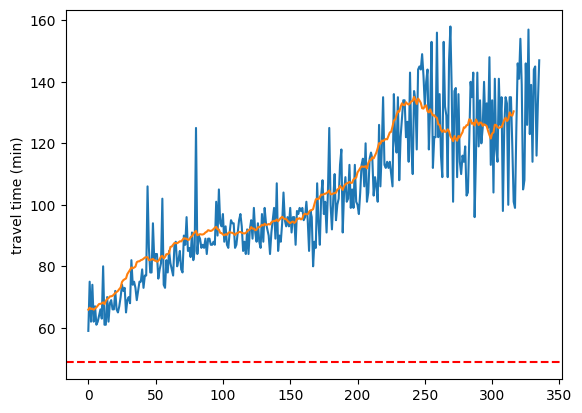

In [107]:
t = gfd.nodes[1006]['object'].times
t2 = t[t[:,1] == 1000][:, 0]
N = 20
tavg = np.convolve(t2, np.ones(N)/N, mode='valid')
# print(tavg)
plt.plot(t2)
plt.plot(tavg)
plt.axhline(y=exavg, ls='--', color='red')
plt.ylabel("travel time (min)")
plt.show()

In [69]:
len(t[t[:,1] == 1000][:,0])

336

In [118]:
total = 0
tremaining = np.zeros(0)
td = np.zeros(0)
for u, v in gfd.edges:
    cars = gfd.edges[(u, v)]['object'].cars
    waited_cars = cars[np.logical_and(cars[:, 3] == 1000, cars[:, 4] == 1006)]
    if len(waited_cars) != 0:
        remtime = (nx.shortest_path_length(gfd, u, 1006, weight='tt_avg') + nx.shortest_path_length(gfd, v, 1006, weight='tt_avg'))/2
        if len(td) == 0:
            td = waited_cars[:, 1]
            tremaining = remtime*np.ones(len(waited_cars[:, 1]))
        else:
            td = np.append(td, waited_cars[:, 1])
            tremaining = np.append(tremaining, remtime*np.ones(len(waited_cars[:, 1])))
        # td.append(waited_cars[:, 1])
    total += len(waited_cars)

td.sort()
print(total)

189


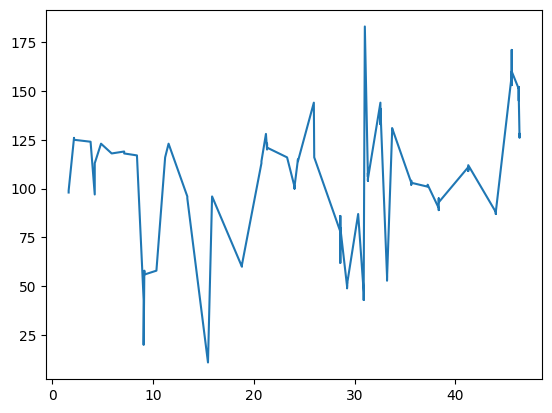

In [122]:
sortind = tremaining.argsort()


plt.plot(tremaining[sortind], td[sortind])
plt.show()

In [22]:
# print(gfd.edges[(201,202)]["object"])
gfd.nodes[202]["object"].waitlist
print(gfd.edges[[202,35]]["object"].tt_avg())
print(gfd.nodes[35]["object"].waitlist[gfd.edges[(35,225)]["object"]])
print(gfd.edges[(35,225)]["object"].cars)

1.9782608695652173
{edge (161, 35) cars:4.0: array([], dtype=int64), edge (202, 35) cars:46.0: array([], dtype=int64), edge (225, 35) cars:13.0: array([], dtype=int64)}
[[1.000e+00 3.000e+01 2.000e+00 1.007e+03 1.011e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 1.000e+01 2.000e+00 1.000e+03 1.001e+03]
 [1.000e+00 2.000e+01 1.000e+00 1.008e+03 1.000e+03]
 [1.000e+00 1.300e+01 1.000e+00 1.000e+03 1.011e+03]
 [1.000e+00 6.300e+01 1.000e+00 1.990e+02 1.001e+03]
 [1.000e+00 1.300e+01 1.000e+00 1.000e+03 1.600e+02]
 [1.000e+00 1.300e+01 1.000e+00 1.000e+03 1.600e+02]
 [1.000e+00 1.200e+01 1.000e+00 1.000e+03 1.001e+03]
 [1.000e+00 1.200e+01 1.000e+00 1.000e+03 1.001e+03]
 [1.000e+00 1.200e+01 1.000e+00 1.000e+03 1.001e+03]
 [1.000e+00 4.700e+01 2.000e+00 1.002e+03 1.008e+03]
 [1.000e+00 1.200e+01 2.000e+00 1.000e+03 1.011e+03]
 [1.000e+00 1.100e+01 1.000e+00 1.000e+03 1.008e+03]
 [1.000e+00 1.100e+01 2.000e+00 1.000e+03 1.011e+03]
 [1.000e+00 1.200e+01 1.000e+00 1.00

In [23]:
nx.path_weight(gfd,[1000,248,247,255,87,179,78,10,79,114,99,112,27,28,1008],weight="tt_avg")

np.float64(25.752951621060284)

In [194]:
for e in gfd.edges:
    if  gfd.edges[e]["object"].size()<0.01*gfd.edges[e]["object"].C(): print(e,gfd.edges[e]["object"].size(),gfd.edges[e]["object"].C(),gfd.edges[e]["tt_avg"])

(0, 86) 0.0 51 1.0196180392156862
(12, 13) 0.0 139 0.53953
(13, 12) 0.0 139 0.53953
(17, 18) 0.0 40 0.14611000000000002
(17, 251) 0.0 58 0.20953000000000005
(18, 17) 0.0 40 0.14611000000000002
(23, 129) 0.0 28 0.10375
(25, 199) 0.0 127 0.23017000000000004
(25, 242) 0.0 509 0.9466385714285714
(32, 33) 0.0 132 0.48796000000000006
(33, 32) 0.0 132 0.48796000000000006
(37, 38) 0.0 44 0.16471000000000002
(37, 158) 0.0 57 0.21263500000000005
(38, 37) 0.0 44 0.16471000000000002
(41, 99) 0.0 26 1.0384719230769233
(47, 120) 0.0 42 0.15481000000000003
(47, 128) 0.0 65 0.23485000000000006
(49, 50) 0.0 25 0.09530999999999999
(50, 49) 0.0 25 0.09530999999999999
(61, 161) 0.0 16 0.06445
(64, 65) 0.0 28 0.10296999999999999
(65, 23) 0.0 43 1.046522093023256
(91, 90) 0.0 56 1.0178673214285714
(96, 97) 0.0 62 0.23571000000000003
(97, 119) 0.0 76 1.078958157894737
(98, 96) 0.0 41 0.15641000000000002
(99, 113) 0.0 35 0.06436
(100, 122) 0.0 40 0.147985
(101, 100) 0.0 68 0.25051
(109, 242) 0.0 109 0.1981300

In [195]:
nx.set_edge_attributes(gfd,{e: (gfd.edges[e]["object"].tt_avg()+gfd.nodes[e[0]]["object"].avg_waittime(gfd.edges[e]["object"]))*(1+gfd.edges[e]["object"].size()/gfd.edges[e]["object"].C()) for e in gfd.edges},"tt_avg") #put edge objects on the edges
path = nx.shortest_path(gfd,1000,1008,weight="tt_avg")
print(path)
for j,i in enumerate(path[:-1]):
    print(i,gfd.edges[(i,path[j+1])]["object"].C())

[1000, 201, 202, 35, 161, 61, 60, 59, 62, 176, 1008]
1000 90
201 157
202 129
35 102
161 16
61 76
60 48
59 49
62 64
176 64


In [196]:
# # traffic_map["cars"] = data1[:,i]
# # traffic_map['textpromt'] = traffic_map['name'].apply(gen_text)
# fig, ax = plt.subplots(1, figsize=(15, 8),dpi = 200)
# cmap = plt.cm.get_cmap('autumn', 120)
# cmap2 = plt.cm.get_cmap('Greens', 120)

# nodes_gpd.plot( linewidth=0.1, ax=ax, edgecolor=".4")

# def update(i):
#     ax.clear()
#     lines_gpd.plot(ax=ax, column=lines_gpd[f"f{i}"]/lines_gpd["capacity"],
#                 cmap='Accent',
#                 linewidth=3,
#                 # legend=True,
#                 # legend_kwds={'label': 'Aantal banen', 'shrink': 0.6},
#                 zorder=1)
#     nodes_gpd.plot(ax=ax, markersize=25, color='black', zorder=2)


#     # ax.clear()
    
#     #plotting edges colored by fractions of capacity
#     # lines_gpd.plot(column=lines_gpd[f"f{i}"]/lines_gpd["capacity"], cmap=cmap, linewidth=0.4, ax=ax,vmin=0,vmax=1)
#     # lines_gpd.apply(lambda x: ax.annotate(text=f"{x['f59']/x['capacity']:.2f}" , xy=x.geometry.centroid.coords[0], ha='center') if x['f59']/x['capacity']>0.9 else 0, axis=1)
# anim = FuncAnimation(fig,update,interval = 100)

# #create a colorr barr
# cax = fig.add_axes([0.92, 0.1, 0.02, 0.78])  # Adjust the position and size as needed
# bar_info = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
# bar_info._A = [] ### geen idee wat dit doet
# cbar = fig.colorbar(bar_info, cax=cax)


In [197]:
print(sources)
for i in sources:
    print(len(gfd.nodes[i]["object"].times),"cars arrived at", i)
    print(len(gfd.nodes[i]["object"].buildup))

160     172.0
199     211.0
245    1000.0
246    1001.0
247    1002.0
252    1003.0
253    1004.0
254    1005.0
255    1006.0
256    1007.0
257    1008.0
258    1009.0
259    1010.0
260    1011.0
Name: nodeID, dtype: float64
3805 cars arrived at 172.0
0
3951 cars arrived at 211.0
679
6241 cars arrived at 1000.0
644
4288 cars arrived at 1001.0
885
3923 cars arrived at 1002.0
850
3748 cars arrived at 1003.0
1116
4173 cars arrived at 1004.0
816
3559 cars arrived at 1005.0
1295
3826 cars arrived at 1006.0
678
4130 cars arrived at 1007.0
21
4181 cars arrived at 1008.0
0
3990 cars arrived at 1009.0
1044
4158 cars arrived at 1010.0
10
4369 cars arrived at 1011.0
2008


In [198]:
# histogrammen

# for i in sources:
#     for j in sources:
#         if i==j: continue
#         data = gfd.nodes[i]["object"].times[gfd.nodes[i]["object"].times[:,1]==j,0]
#         if np.sum(gfd.nodes[i]["object"].times[:,1]==j)==0: print(f"no cars from {j} have arrived at {i}")
#         else:
#             plt.hist(data,bins=int((max(data)-min(data))))
#             plt.show()
#             print(f'average time from {j} to {i} is {np.average(data)} +/- {np.std(data)}')

### comparing to data on https://staat-van-fryslan.hub.arcgis.com/pages/bda2fb83b28b4707840ee69c05cd0146

In [199]:
arr_forw=np.zeros(len(lines_gpd))
arr_backw=np.zeros(len(lines_gpd))
for index,(start,end) in enumerate(zip(lines_gpd["node_start"],lines_gpd["node_end"])):
    # if (start,end) in gfd.edges:
    arr_forw[index]=gfd.edges[(start,end)]["object"].leftthismin
    arr_backw[index]=gfd.edges[(end,start)]["object"].leftthismin
saved_gpd=pd.concat((lines_gpd,pd.DataFrame(arr_forw,columns=["leftforw"]),pd.DataFrame(arr_backw,columns=["leftback"])),axis=1)
saved_gpd.to_csv("precookeddata200m")

In [200]:
loaded_gpd=pd.read_csv("precookeddata200m")

In [201]:
loaded_gpd["leftforw"]

0      0.379302
1      0.694947
2      0.090267
3      1.082586
4      0.378257
         ...   
307    2.485589
308    1.773929
309    3.747786
310    3.930427
311    2.048459
Name: leftforw, Length: 312, dtype: float64

In [202]:
gfd.edges[(202,35)]["object"].leftthismin

6.8699888382012055

In [203]:
f=open(f"initvalresults\\runa{runnr}","w")
f.write(f"settings:{spawn_hoeveelheden}\n")
def carspermin(workday_avg,part_during_day=.8):return workday_avg*part_during_day/12/60
def compare_data(edges,counter_id,workday_avg,name,part_during_day=.8):
    # for i in edges: 
    #     print(i)
    #     print(loaded_gpd[(loaded_gpd["node_start"]==i[0])*(loaded_gpd["node_end"]==i[1])]["leftforw"].iloc[0])
    counts=[]
    for i in edges:
        if len(loaded_gpd[(loaded_gpd["node_start"]==i[0])*(loaded_gpd["node_end"]==i[1])]["leftforw"])>=1: counts.append(loaded_gpd[(loaded_gpd["node_start"]==i[0])*(loaded_gpd["node_end"]==i[1])]["leftforw"].iloc[0])
        else: counts.append(loaded_gpd[(loaded_gpd["node_start"]==i[1])*(loaded_gpd["node_end"]==i[0])]["leftback"].iloc[0])
    line=f"counter {counter_id}:{carspermin(workday_avg,part_during_day)}, model: {sum(counts)} {counts} name:{name}"
    print(line)
    return carspermin(workday_avg,part_during_day)-sum(counts),line
counters=[([(202,35),(35,202)],101608,24097,.807,"oost Leeuwarden"),([(73,74),(74,73)],101625,8858,.815,"leeuwarden ZW"),([(205,206),(206,205)],101612,19083,.811,"bergum ZO"),([(155,205),(205,155)],101615,18749,.813,"Bergum NW"),([(204,205),(205,204)],101647,7763,.823,"Bergum ZW"),([(240,241),(241,240)],101606,11187,.842,"sneek NO"),([(164,82),(82,164)],101607,10613,.826,"sneek Z"),([(502,503),(503,502)],101650,4393,.805,"Heerenveen Zuid") \
          ,([(142,143),(143,142)],101673,9766,.798,"Drachten N"),([(166,63),(63,166)],101614,14396,.822,"Dokkum Z"),([(176,63),(63,176)],101671,9950,.844,"Dokkum W"),([(140,76),(76,140)],101635,3561,.83,""),([(180,207),(207,180)],101601,9822,.817,"Wolvega O"),([(70,71),(71,70)],101668,11147,.811,"Lemmer W"),([(136,134),(134,136)],101676,6883,.829,"Harlingen O"),(([(136,16),(16,136)],101643,2707,.798,"Harlingen N")),\
            ([(137,14),(14,137)],101637,3407,.798,"FranekerN"),([(121,45),(45,121)],101636,2948,.834,"Franeker ZO"),([(117,125),(125,117)],101623,8660,.816,"Bolsward Z"),([(115,116),(116,115)],101624,8445,.816,"Bolsward N"),([(252,160),(160,252)],101674,16267,.828,"Oosterwolde N"),([(178,160),(160,178)],101656,5077,.861,"Oosterwolde W")]
sq_sum=0
for edges,counter_id,workday_avg,part_during_day,name in counters:
    dist,line=compare_data(edges,counter_id,workday_avg,name,part_during_day)
    f.write(line+"\n")
    sq_sum+=dist**2
f.write(f"{np.sqrt(sq_sum)}")
f.close()
print (np.sqrt(sq_sum))

counter 101608:27.008720833333335, model: 12.96554710969475 [6.8699888382012055, 6.095558271493544] name:oost Leeuwarden
counter 101625:10.026763888888889, model: 7.3146197528179915 [4.6526061622755295, 2.662013590542462] name:leeuwarden ZW
counter 101612:21.49487916666667, model: 7.651463454953692 [3.270932214281763, 4.380531240671929] name:bergum ZO
counter 101615:21.17074583333333, model: 8.030779440723459 [3.7965340560059584, 4.2342453847175] name:Bergum NW
counter 101647:8.873540277777778, model: 5.611120355657328 [2.0336779923239465, 3.5774423633333816] name:Bergum ZW
counter 101606:13.082574999999999, model: 11.249470933966665 [5.46811481797651, 5.781356115990155] name:sneek NO
counter 101607:12.175469444444444, model: 7.316879922632906 [4.772155984013434, 2.544723938619472] name:sneek Z
counter 101650:4.9116180555555555, model: 14.768059788045322 [6.876944014827259, 7.891115773218063] name:Heerenveen Zuid
counter 101673:10.823983333333333, model: 10.418255008182092 [5.287055262

In [204]:
gfd.edges[(176,63)]["object"].cars

array([[1.000e+00, 6.300e+01, 1.000e+00, 1.010e+03, 1.008e+03],
       [1.000e+00, 1.430e+02, 1.000e+00, 1.009e+03, 1.008e+03],
       [1.000e+00, 7.900e+01, 1.000e+00, 1.003e+03, 1.008e+03],
       [1.000e+00, 6.100e+01, 2.000e+00, 1.004e+03, 1.008e+03],
       [1.000e+00, 1.440e+02, 2.000e+00, 1.009e+03, 1.008e+03],
       [1.000e+00, 5.400e+01, 2.000e+00, 1.001e+03, 1.008e+03],
       [1.000e+00, 3.100e+01, 1.000e+00, 1.000e+03, 1.008e+03],
       [1.000e+00, 8.100e+01, 2.000e+00, 1.003e+03, 1.720e+02],
       [1.000e+00, 1.100e+01, 2.000e+00, 1.008e+03, 1.011e+03],
       [1.000e+00, 3.000e+00, 2.000e+00, 1.008e+03, 1.000e+03],
       [1.000e+00, 3.000e+00, 2.000e+00, 1.008e+03, 1.011e+03],
       [1.000e+00, 4.000e+00, 1.000e+00, 1.008e+03, 1.720e+02],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00,